In [1]:
import TunaSims
import numpy as np
from funcOb import func_ob
import pandas as pd
import datasetBuilder
import tools_fast
from sklearn.metrics import roc_auc_score
import scipy
from sklearn.ensemble import HistGradientBoostingClassifier as hgbc
import time
import copy

In [2]:

def _weight_intensity_by_entropy(x):
    WEIGHT_START = 0.25
    ENTROPY_CUTOFF = 3
    weight_slope = (1 - WEIGHT_START) / ENTROPY_CUTOFF

    if np.sum(x) > 0:
        entropy_x = scipy.stats.entropy(x)
        if entropy_x < ENTROPY_CUTOFF:
            weight = WEIGHT_START + weight_slope * entropy_x
            x = np.power(x, weight)
            x_sum = np.sum(x)
            x = x / x_sum
    return x

def ppm(base, ppm):
    """
    convert ppm threshold to dalton based on precursor exact mass (base)
    """

    return base * (ppm / 1e6)



In [3]:
def harmonic_mean_distance(p, q):
    r"""
    Harmonic mean distance:

    .. math::

        1-2\sum(\frac{P_{i}Q_{i}}{P_{i}+Q_{i}})
    """
    p = _weight_intensity_by_entropy(p)
    q = _weight_intensity_by_entropy(q)
    return 2 * np.sum(p * q / (p + q))

def lorentzian_distance(p, q):
    r"""
    Lorentzian distance:

    .. math::

        \sum{\ln(1+|P_i-Q_i|)}
    """
    p = _weight_intensity_by_entropy(p)
    q = _weight_intensity_by_entropy(q)
    return 1 - np.sum(np.log(1 + np.abs(p - q)))

def matusita_distance(p, q):
    r"""
    Matusita distance:

    .. math::

        \sqrt{\sum(\sqrt{P_{i}}-\sqrt{Q_{i}})^2}
    """
    p = _weight_intensity_by_entropy(p)
    q = _weight_intensity_by_entropy(q)
    return 1- np.sum(np.power(np.sqrt(p) - np.sqrt(q), 2))

def probabilistic_symmetric_chi_squared_distance(p, q):
    r"""
    Probabilistic symmetric χ2 distance:

    .. math::

        \frac{1}{2} \times \sum\frac{(P_{i}-Q_{i}\ )^2}{P_{i}+Q_{i}\ }
    """
    p = _weight_intensity_by_entropy(p)
    q = _weight_intensity_by_entropy(q)
    return 1- (1 / 2 * np.sum(np.power(p - q, 2) / (p + q)))

def entropy_distance(p, q):
    r"""
    Unweighted entropy distance:

    .. math::

        -\frac{2\times S_{PQ}-S_P-S_Q} {ln(4)}, S_I=\sum_{i} {I_i ln(I_i)}
    """
    p = _weight_intensity_by_entropy(p)
    q = _weight_intensity_by_entropy(q)
    merged = p + q
    entropy_increase = 2 * \
                       scipy.stats.entropy(merged) - scipy.stats.entropy(p) - \
                       scipy.stats.entropy(q)
    
    return 1 - entropy_increase

def dot_product_distance(p, q):
    r"""
    Dot product distance:

    .. math::

        1 - \sqrt{\frac{(\sum{Q_iP_i})^2}{\sum{Q_i^2\sum P_i^2}}}
    """
    p = _weight_intensity_by_entropy(p)
    q = _weight_intensity_by_entropy(q)    
    score = np.power(np.sum(q * p), 2) / (
        np.sum(np.power(q, 2)) * np.sum(np.power(p, 2))
    )
    return np.sqrt(score)

def sigmoid(z):
    
        return 1/(1 + np.exp(-z))


Create Matches DFs

In [4]:
create_new_dataset = False
if create_new_dataset:
    n_dfs = 3
    set_names = ['train','val','test']
    dataset_sizes = 2e6

    input_df = pd.read_pickle('/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist20.pkl')
    input_df.sort_values(by = 'inchi_base', inplace = True)
    input_df['queryID'] = [i for i in range(len(input_df))]
    print(len(input_df))
    all_bases = list(set(input_df['inchi_base']))
    print(len(all_bases))
    np.random.shuffle(all_bases)

    base_sets = list()
    separated_dfs = list()
    assigned_inds = list()

    for i in range(n_dfs):
        base_set = all_bases[int(i * len(all_bases)/n_dfs): int((i + 1) *len(all_bases)/n_dfs)]
        base_sets.append(set(base_set))
        assigned_inds.append(list())

    for i in range(len(input_df)):

        for j in range(len(base_sets)):

            if input_df.iloc[i]['inchi_base'] in base_sets[j]:

                assigned_inds[j].append(i)
                break

    for i in range(n_dfs):   
        datasetBuilder.create_matches_df_chunk(input_df.iloc[assigned_inds[i]], 
                                                input_df.iloc[assigned_inds[i]],
                                                10,
                                                dataset_sizes,
                                                dataset_sizes,
                                                f'/Users/jonahpoczobutt/projects/TunaRes/NIST20_inputs/{set_names[i]}',
                                                f'loggy.log')
        print(i)
            

Create old similarities

In [5]:
sims_output_dir = '/Users/jonahpoczobutt/projects/TunaRes/oldSimRes'
if create_new_dataset:

     demo_matches = pd.read_pickle('/Users/jonahpoczobutt/projects/TunaRes/Nist20_inputs/train/chunk_1.pkl')
     demo_matches_val = pd.read_pickle('/Users/jonahpoczobutt/projects/TunaRes/Nist20_inputs/val/chunk_1.pkl')

     queries = list()
     targets = list()
     indices = list()
     for i in range(len(demo_matches)):

          query = demo_matches.iloc[i]['query'][demo_matches.iloc[i]['query'][:,0] < demo_matches.iloc[i]['precquery'] - ppm(demo_matches.iloc[i]['precquery'],3)]
          target = demo_matches.iloc[i]['target'][demo_matches.iloc[i]['target'][:,0] < demo_matches.iloc[i]['prectarget'] - ppm(demo_matches.iloc[i]['prectarget'],3)]

          if len(query) > 0 and len(target) > 0:
               indices.append(i)
               queries.append(query)
               targets.append(target)

     demo_matches = demo_matches.iloc[indices]
     demo_matches['query'] = queries
     demo_matches['target'] = targets

     queries = list()
     targets = list()
     indices = list()
     for i in range(len(demo_matches_val)):

          query = demo_matches_val.iloc[i]['query'][demo_matches_val.iloc[i]['query'][:,0] < demo_matches_val.iloc[i]['precquery'] - ppm(demo_matches_val.iloc[i]['precquery'],3)]
          target = demo_matches_val.iloc[i]['target'][demo_matches_val.iloc[i]['target'][:,0] < demo_matches_val.iloc[i]['prectarget'] - ppm(demo_matches_val.iloc[i]['prectarget'],3)]

          if len(query) > 0 and len(target) > 0:
               indices.append(i)
               queries.append(query)
               targets.append(target)

     demo_matches_val = demo_matches_val.iloc[indices]
     demo_matches_val['query'] = queries
     demo_matches_val['target'] = targets

     demo_matches.to_pickle('/Users/jonahpoczobutt/projects/TunaRes/inputs/demo_matches_no_prec.pkl')
     demo_matches_val.to_pickle('/Users/jonahpoczobutt/projects/TunaRes/inputs/demo_matches_val_no_prec.pkl')

     sim_names = ['prob','matusita','entropy','dot','lorentzian','harmonic']
     distances = [probabilistic_symmetric_chi_squared_distance,
               matusita_distance,
               entropy_distance,
               dot_product_distance,
               lorentzian_distance,
               harmonic_mean_distance]

     for _ in range(len(sim_names)):

          matched_scores_val = list()
          for i in range(len(demo_matches_val)):
          
               matched = tools_fast.match_spectrum(demo_matches_val.iloc[i]['query'], demo_matches_val.iloc[i]['target'], ms2_da = 0.05)
               matched_scores_val.append(sigmoid(distances[_](matched[:,1]/sum(matched[:,1]), matched[:,2]/sum(matched[:,2]))))

          np.save(f'{sims_output_dir}/val_{sim_names[_]}.npy', np.array(matched_scores_val))

          matched_scores = list()
          for i in range(len(demo_matches)):

               matched = tools_fast.match_spectrum(demo_matches.iloc[i]['query'], demo_matches.iloc[i]['target'], ms2_da = 0.05)
               matched_scores.append(sigmoid(distances[_](matched[:,1]/sum(matched[:,1]), matched[:,2]/sum(matched[:,2]))))

          np.save(f'{sims_output_dir}/train_{sim_names[_]}.npy', np.array(matched_scores))


Original Metric Performance

In [6]:
sim_names = ['prob','matusita','entropy','dot','lorentzian','harmonic']

demo_matches = pd.read_pickle('/Users/jonahpoczobutt/projects/TunaRes/inputs/demo_matches_no_prec.pkl')
demo_matches_val = pd.read_pickle('/Users/jonahpoczobutt/projects/TunaRes/inputs/demo_matches_val_no_prec.pkl')

demo_matches['score'] = 1 * demo_matches['InchiCoreMatch']
demo_matches_val['score'] = 1 * demo_matches_val['InchiCoreMatch']
demo_matches['queryID_target_base'] = [str(demo_matches.iloc[i]['queryID']) + '_' + demo_matches.iloc[i]['target_base'] for i in range(len(demo_matches))]

calc_base_sims = False
if calc_base_sims:
    for sim in sim_names:
        demo_matches['preds'] = np.load(f'{sims_output_dir}/train_{sim}.npy')
        demo_matches_val['preds'] = np.load(f'{sims_output_dir}/val_{sim}.npy')

        temp = demo_matches.groupby(by=['queryID','target_base']).apply(lambda x: x[x['preds'] == max(x['preds'])].iloc[0])
        temp_val = demo_matches_val.groupby(by=['queryID','target_base']).apply(lambda x: x[x['preds'] == max(x['preds'])].iloc[0])

        print(sim, round(roc_auc_score(temp['score'] , temp['preds']), 4), round(roc_auc_score(temp_val['score'] , temp_val['preds']), 4))

In [8]:
init_vals = {
    'mult_a' : 0.001,
    'mult_b': 1,
    'dif_a': 0.001,
    'dif_b':1,
    'add_norm_b' : 1,
    # 'target_normalized_intensity_int': 0,
    # 'query_normalized_intensity_int': 0,
    'target_normalized_intensity_a': 0.1,
    'query_normalized_intensity_a': 0.1,
    'target_normalized_intensity_b': 0.1,
    'query_normalized_intensity_b': 0.1,
    # 'target_normalized_intensity_c': 0.1,
    # 'query_normalized_intensity_c': 0.1,
    # 'target_mz_int': 1e-10,
    # 'query_mz_int': 1e-10,
    # 'target_mz_a': 0.001,
    # 'query_mz_a': 0.001,
    # 'target_mz_b': 0.001,
    # 'query_mz_b': 0.001,
    # 'target_mz_c': 0.001,
    # 'query_mz_c': 0.001,
    # 'target_intensity_int': 0,
    # 'query_intensity_int': 0,
    # 'target_intensity_a': 1,
    # 'query_intensity_a': 1,
    # 'target_intensity_b': 1,
    # 'query_intensity_b': 1,
    # 'target_intensity_c': 1,
    # 'query_intensity_c': 1,
    }

init_vals_2 = {
    'mult_a' : 0.001,
    'mult_b': 1,
    'dif_a': 0.001,
    'dif_b':1,
    'add_norm_b' : 1,
    # 'target_normalized_intensity_int': 0,
    # 'query_normalized_intensity_int': 0,
    'target_normalized_intensity_a': 0.1,
    'query_normalized_intensity_a': 0.1,
    'target_normalized_intensity_b': 0.1,
    'query_normalized_intensity_b': 0.1,
    # 'target_normalized_intensity_c': 0.1,
    # 'query_normalized_intensity_c': 0.1,
    'target_mz_int': 1e-10,
    'query_mz_int': 1e-10,
    'target_mz_a': 0.001,
    'query_mz_a': 0.001,
    'target_mz_b': 0.001,
    'query_mz_b': 0.001,
    # 'target_mz_c': 0.001,
    # 'query_mz_c': 0.001,
    # 'target_intensity_int': 0,
    # 'query_intensity_int': 0,
    # 'target_intensity_a': 1,
    # 'query_intensity_a': 1,
    # 'target_intensity_b': 1,
    # 'query_intensity_b': 1,
    # 'target_intensity_c': 1,
    # 'query_intensity_c': 1,
    }

init_vals_3 = {
    'mult_a' : 0.001,
    'mult_b': 1,
    'dif_a': 0.001,
    'dif_b':1,
    'add_norm_b' : 1,
    'target_normalized_intensity_int': 0,
    'query_normalized_intensity_int': 0,
    'target_normalized_intensity_a': 1,
    'query_normalized_intensity_a': 1,
    'target_normalized_intensity_b': 1,
    'query_normalized_intensity_b': 1,
    # 'target_normalized_intensity_c': 0.1,
    # 'query_normalized_intensity_c': 0.1,
    'target_mz_int': 0,
    'query_mz_int': 0,
    'target_mz_a': 1,
    'query_mz_a': 1,
    'target_mz_b': 0.,
    'query_mz_b': 0.,
    # 'target_mz_c': 0.001,
    # 'query_mz_c': 0.001,
    # 'target_intensity_int': 0,
    # 'query_intensity_int': 0,
    # 'target_intensity_a': 1,
    # 'query_intensity_a': 1,
    # 'target_intensity_b': 1,
    # 'query_intensity_b': 1,
    # 'target_intensity_c': 1,
    # 'query_intensity_c': 1,
    }

regularization_grad = lambda x: 0.

fixed_vals = {'sigmoid_score' : True, 
              'weight_combine': 'multiply'
    }



bounds = {'add_norm_b': (0, 2),
          'mult_b': (1e-10, 2),
          'add_norm_a': (1e-10, 3),
          'dif_b': (1e-10, 2),
          'dif_a':(-1.5,1.5),
          'mult_a': (-1.5,1.5),
          'target_normalized_intensity_int': (-0.2,1),
          'query_normalized_intensity_int': (-0.2,1),
          'target_normalized_intensity_a': (1e-10,2),
          'query_normalized_intensity_a': (1e-10,2),
          'target_normalized_intensity_b': (0,2),
          'query_normalized_intensity_b': (0,2),
          'target_normalized_intensity_c': (-2,2),
          'query_normalized_intensity_c': (-2,2),
          'target_mz_b': (-2,2),
          'query_mz_b': (-2,2),
          'target_mz_a': (-2,2),
          'query_mz_a': (-2,2),
          'target_mz_int': (-0.2,1),
          'query_mz_int': (-0.2,1),
          'target_mz_c': (-2,2),
          'query_mz_c': (-2,2),
           'target_intensity_int': (-0.2,1),
           'query_intensity_int': (-0.2,1),
          'target_intensity_a': (1e-10,2),
          'query_intensity_a': (1e-10,2),
          'target_intensity_b': (1e-10,2),
          'query_intensity_b': (1e-10,2),
          'target_intensity_c': (1e-10,2),
          'query_intensity_c': (1e-10,2),
          }


init_names = ['intensity', 'full']
inits = [init_vals, init_vals_3]
ad_params = [(0.8,0.3), (0.8, 0.4), (0.8, 0.5)]
func_obs = list()

for i in range(1):
    for momentum in [None]:
        for sched in ['ad']:
            for i in range(len(inits)):
                for ad_param in ad_params:
                
                    func_obs.append(func_ob(f'{momentum}_{sched}_{init_names[i]}_{ad_param}',
                                sim_func = TunaSims.ExpandedTuna,
                                init_vals = inits[i].copy(),
                                fixed_vals = fixed_vals,
                                regularization_grad = regularization_grad,
                                bounds = bounds,
                                max_iter = 1e6,
                                learning_rates = 0.001,
                                momentum_type = momentum,
                                learning_rate_scheduler = sched,
                                learning_beta = 0.5,
                                momentum_beta = 0.3,
                                tol = 0,
                                balance_classes = True,
                                groupby_column = 'queryID_target_base',
                                ad_int = ad_param[0],
                                ad_slope= ad_param[1]))
                
print(len(func_obs))

6


In [9]:
demo_matches = pd.read_pickle('/Users/jonahpoczobutt/projects/TunaRes/inputs/demo_matches_no_prec.pkl')
demo_matches_val = pd.read_pickle('/Users/jonahpoczobutt/projects/TunaRes/inputs/demo_matches_val_no_prec.pkl')

demo_matches['score'] = 1 * demo_matches['InchiCoreMatch']
demo_matches_val['score'] = 1 * demo_matches_val['InchiCoreMatch']
demo_matches['queryID_target_base'] = [str(demo_matches.iloc[i]['queryID']) + '_' + demo_matches.iloc[i]['target_base'] for i in range(len(demo_matches))]

train_auc_top = {i.name: list() for i in func_obs}
val_auc_top = {i.name: list() for i in func_obs}

train_auc_all = {i.name: list() for i in func_obs}
val_auc_all = {i.name: list() for i in func_obs}

train_times = {i.name: list() for i in func_obs}

absolutes = [0, 1e4, 5e4]
offsets = [absolutes[i+1] - absolutes[i] for i in range(len(absolutes)-1)]

reps = 1

trained_obs = []

for model in func_obs:

    for _ in range(reps):

        model_ = copy.deepcopy(model)

        accumulated = 0
        accumulated_time = 0
        train_aucs_top = list()
        val_aucs_top = list()
        train_aucs_all = list()
        val_aucs_all = list()
        trained_obs_sub = list()

        for i in offsets:
            
            model_.max_iter = i
            
            start = time.time()
            model_.fit(demo_matches)
            accumulated_time += time.time() - start

            demo_matches['preds'] = [model_.sim_func.predict(demo_matches.iloc[i]['query'], demo_matches.iloc[i]['target'],demo_matches.iloc[i]['precquery'], demo_matches.iloc[i]['prectarget'], grads = False) for i in range(len(demo_matches))]
            demo_matches_val['preds'] = [model_.sim_func.predict(demo_matches_val.iloc[i]['query'], demo_matches_val.iloc[i]['target'], demo_matches_val.iloc[i]['precquery'], demo_matches_val.iloc[i]['prectarget'], grads = False) for i in range(len(demo_matches_val))]

            train_aucs_all.append(round(roc_auc_score(demo_matches['score'] , demo_matches['preds']), 4)) 
            val_aucs_all.append(round(roc_auc_score(demo_matches_val['score'] , demo_matches_val['preds']),4))

            temp = demo_matches.groupby(by=['queryID','target_base']).apply(lambda x: x[x['preds'] == max(x['preds'])].iloc[0])
            temp_val = demo_matches_val.groupby(by=['queryID','target_base']).apply(lambda x: x[x['preds'] == max(x['preds'])].iloc[0])

            train_aucs_top.append(round(roc_auc_score(temp['score'] , temp['preds']), 4)) 
            val_aucs_top.append(round(roc_auc_score(temp_val['score'] , temp_val['preds']),4))

            accumulated += model_.max_iter

        trained_obs_sub.append(copy.deepcopy(model_))
        
    trained_obs.append(trained_obs_sub)
    train_times[model.name].append(round(accumulated_time/60, 4))
    train_auc_all[model.name].append(train_aucs_all)
    train_auc_top[model.name].append(train_aucs_top)
    val_auc_all[model.name].append(val_aucs_all)
    val_auc_top[model.name].append(val_aucs_top)

    print(model.name)

    model_1 = model_

balanced
pred_val=0.5065956686975224
loss_grad=-0.9868086626049553
grad=-0.027046744207195782
unweighted_step=-0.027046744207195782
learning_rate=0.0009500000000000001
key='mult_a', -0.5, current_value=0.001, updated=0.001025694406996836, learning_rate=0.0009500000000000001, grad=-0.027046744207195782
loss_grad=-0.9868086626049553
grad=0.00014041359123899994
unweighted_step=0.00014041359123899994
learning_rate=0.0009500000000000001
key='mult_b', 0.5, current_value=1, updated=0.9999998666070883, learning_rate=0.0009500000000000001, grad=0.00014041359123899994
loss_grad=-0.9868086626049553
grad=-6.480867846981509
unweighted_step=-6.480867846981509
learning_rate=0.0009500000000000001
key='dif_a', -0.5, current_value=0.001, updated=0.007156824454632434, learning_rate=0.0009500000000000001, grad=-6.480867846981509
loss_grad=-0.9868086626049553
grad=0.01812037169742578
unweighted_step=0.01812037169742578
learning_rate=0.0009500000000000001
key='dif_b', 0.5, current_value=1, updated=0.9999827

KeyboardInterrupt: 

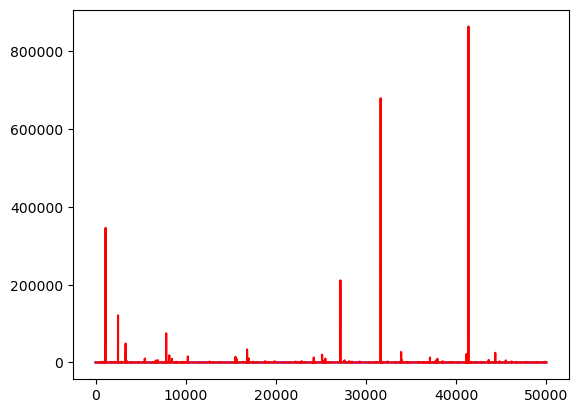

In [186]:
import matplotlib.pyplot as plt
pos = 1
neg = -2
pos_prob = 0.5
neg_prob = 0.5

a_ = list(np.random.choice([neg, pos], 50000, p = [0.5,0.5]))
beta = 0.5

running = 0
accum_beta = 0.5
running_scale = 0.1
step = 1
steps_ = list()
runnings_ = list()
for i in a_:

    running = running * beta + i * (1 - beta)
    runnings_.append(running)
    running_scale = running_scale * accum_beta + abs(i) * (1 - accum_beta) 
    #step *=  abs(running) / running_scale
    steps_.append(abs(running) / running_scale)
    #print(f'{round(running,2)}, {round(running_std,2)}, {round(abs(running) / running_std,2)}, {round(step,2)}')

plt.plot(range(len(steps_)), steps_, c = 'b')

a = list(np.random.choice([-1,1], 50000, p = [-neg/ (pos - neg), pos / (pos - neg)]))
beta = 0.5

running = 0
accum_beta = 0.5
running_std = 0.1
step = 1
steps = list()
runnings = list()
for i in a:

    running = running * beta + i * (1 - beta)
    runnings.append(running)
    running_std = running_std * accum_beta + abs(i - running) * (1 - accum_beta) 
    step *=  abs(running) / running_std
    steps.append(abs(running) / running_std)
    #print(f'{round(running,2)}, {round(running_std,2)}, {round(abs(running) / running_std,2)}, {round(step,2)}')

plt.plot(range(len(steps)), steps, c = 'r')

In [187]:
print(np.mean(steps_) , np.mean(steps))
print(np.mean(runnings_) , np.mean(runnings))
print(np.mean(a_)/ np.mean(np.abs(a_)) , np.mean(a))

0.5273525569041206 122.28572328095206
-0.506672194865761 -0.32914025910411066
-0.3372741675653366 -0.32916


In [ ]:
model_.sim_func.grads1_score_agg

In [ ]:
train_auc_top

In [ ]:
train_auc_top

In [ ]:
val_auc_top

In [ ]:
train_times

In [ ]:
print(yool)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(temp['preds'], bins = 100)
plt.title('Preds Train')
plt.show()

plt.hist(temp_val['preds'], bins = 100)
plt.title('Preds Val')
plt.show()

In [ ]:
temp['residual'] = abs(temp['score'] - temp['preds'])

In [ ]:
for i in model_1.init_vals:
    print(i, getattr(model_1.sim_func,i))

Grab only inchicores where performance was bad

In [ ]:
temp['residual'] = np.abs(temp['score'] - temp['preds'])
median_residual = np.median(temp['residual'])

bad_ids = list()
for i in range(len(temp)):

    if temp.iloc[i]['residual'] >= median_residual:
        bad_ids.append(temp.iloc[i]['queryID_target_base'])

bad_ids = set(bad_ids)

residual_inds = list()
for i in range(len(demo_matches)):

    if demo_matches.iloc[i]['queryID_target_base'] in bad_ids:

        residual_inds.append(i)

demo_matches = demo_matches.iloc[residual_inds]
print(len(demo_matches))
print(len(bad_ids))

Round 2

In [ ]:

train_auc_top = {i.name: list() for i in func_obs}
val_auc_top = {i.name: list() for i in func_obs}

train_auc_all = {i.name: list() for i in func_obs}
val_auc_all = {i.name: list() for i in func_obs}

train_times = {i.name: list() for i in func_obs}

absolutes = [0, 1e5]
offsets = [absolutes[i+1] - absolutes[i] for i in range(len(absolutes)-1)]

reps = 1

trained_obs = []

for model in func_obs[:1]:

    for _ in range(reps):

        model_ = copy.deepcopy(model)

        accumulated = 0
        accumulated_time = 0
        train_aucs_top = list()
        val_aucs_top = list()
        train_aucs_all = list()
        val_aucs_all = list()
        trained_obs_sub = list()

        for i in offsets:
            
            model_.max_iter = i
            
            start = time.time()
            model_.fit(demo_matches)
            accumulated_time += time.time() - start

            demo_matches['preds'] = [model_.sim_func.predict(demo_matches.iloc[i]['query'], demo_matches.iloc[i]['target'],demo_matches.iloc[i]['precquery'], demo_matches.iloc[i]['prectarget'], grads = False) for i in range(len(demo_matches))]
            demo_matches_val['preds'] = [model_.sim_func.predict(demo_matches_val.iloc[i]['query'], demo_matches_val.iloc[i]['target'], demo_matches_val.iloc[i]['precquery'], demo_matches_val.iloc[i]['prectarget'], grads = False) for i in range(len(demo_matches_val))]

            train_aucs_all.append(round(roc_auc_score(demo_matches['score'] , demo_matches['preds']), 4)) 
            val_aucs_all.append(round(roc_auc_score(demo_matches_val['score'] , demo_matches_val['preds']),4))

            temp = demo_matches.groupby(by=['queryID','target_base']).apply(lambda x: x[x['preds'] == max(x['preds'])].iloc[0])
            temp_val = demo_matches_val.groupby(by=['queryID','target_base']).apply(lambda x: x[x['preds'] == max(x['preds'])].iloc[0])

            train_aucs_top.append(round(roc_auc_score(temp['score'] , temp['preds']), 4)) 
            val_aucs_top.append(round(roc_auc_score(temp_val['score'] , temp_val['preds']),4))

            accumulated += model_.max_iter

        trained_obs_sub.append(copy.deepcopy(model_))
        
    trained_obs.append(trained_obs_sub)
    train_times[model.name].append(round(accumulated_time/60, 4))
    train_auc_all[model.name].append(train_aucs_all)
    train_auc_top[model.name].append(train_aucs_top)
    val_auc_all[model.name].append(val_aucs_all)
    val_auc_top[model.name].append(val_aucs_top)

    print(model.name)

    model_2 = model_

In [ ]:
val_auc_top

In [ ]:
print(yool)

In [ ]:
for i in model_1.init_vals:
    print(i, getattr(model_1.sim_func,i))

In [ ]:
for i in model_2.init_vals:
    print(i, getattr(model_2.sim_func,i))

Round 3

In [ ]:

#maintain mapping to 0 1 interval
demo_matches['score'] = (demo_matches['score'] - preds_combined + 1) / 2
plt.hist(demo_matches['score'], bins = 100)
plt.title('train_residuals')
plt.show()

testerooni = func_ob('teesterooni',
                     sim_func = TunaSims.ExpandedTuna,
                     init_vals = init_vals,
                     fixed_vals = fixed_vals,
                     regularization_grad = regularization_grad,
                     bounds = bounds,
                     max_iter = 1000000,
                     lambdas = 0.001,
                     tol = 0,
                     balance_classes = False)

testerooni.fit(demo_matches, verbose = 100000)
print(testerooni.converged)


preds_3 = np.array([testerooni.sim_func.predict(demo_matches.iloc[i]['query'], demo_matches.iloc[i]['target'],demo_matches.iloc[i]['precquery'], demo_matches.iloc[i]['prectarget']) for i in range(len(demo_matches))])
preds_val_3 = np.array([testerooni.sim_func.predict(demo_matches_val.iloc[i]['query'], demo_matches_val.iloc[i]['target'], demo_matches_val.iloc[i]['precquery'], demo_matches_val.iloc[i]['prectarget']) for i in range(len(demo_matches_val))])


In [ ]:
all_scores_train = dict()
all_scores_val = dict()

for sim in sim_names:

    all_scores_train[sim] = np.load(f'{sims_output_dir}/train_{sim}.npy')
    all_scores_val[sim] = np.load(f'{sims_output_dir}/val_{sim}.npy')

all_scores_train['preds'] = preds
all_scores_val['preds'] = preds_val

all_scores_train['preds2'] = preds_2
all_scores_val['preds2'] = preds_val_2

all_scores_train['preds3'] = preds_3
all_scores_val['preds3'] = preds_val_3

all_scores_train['score'] = original_labels_train
all_scores_val['score'] = original_labels_val

train_data = pd.DataFrame(all_scores_train)
val_data = pd.DataFrame(all_scores_val)



Train Correlations


In [ ]:
train_data.corr()

Val Correlations

In [ ]:
val_data.corr()

Now Train Models with Each Pair/Triplet of Sim Scores Old and New

Create column groups

In [ ]:
old_sim_combos = list()
for sim1 in sim_names:
    for sim2 in sim_names:
        for sim3 in sim_names:

            old_sim_combos.append(list(set([sim1, sim2, sim3])))

new_sim_combos = list()
new_sims = ['preds', 'preds2', 'preds3']
for sim1 in new_sims:
    for sim2 in new_sims:
        for sim3 in new_sims:  

            new_sim_combos.append(list(set([sim1, sim2, sim3])))

Train Models for each Column Group

In [ ]:
sim_performance = dict()

for combo in old_sim_combos:

    print(combo)

    model = hgbc()
    model.fit(train_data[combo], train_data['score'])
    train_auc = roc_auc_score(original_labels_train, model.predict_proba(train_data[combo])[:,1])
    val_auc = roc_auc_score(original_labels_val, model.predict_proba(val_data[combo])[:,1])

    sim_performance['_'.join(combo)] = (train_auc, val_auc)

sim_performance_new = dict()
for combo in new_sim_combos:

    print(combo)

    model = hgbc()
    model.fit(train_data[combo], train_data['score'])
    train_auc = roc_auc_score(original_labels_train, model.predict_proba(train_data[combo])[:,1])
    val_auc = roc_auc_score(original_labels_val, model.predict_proba(val_data[combo])[:,1])

    sim_performance_new['_'.join(combo)] = (train_auc, val_auc)



In [ ]:
print(np.mean([val[1] for key, val in sim_performance.items() if len(key.split('_'))==1]))
print(np.mean([val[1] for key, val in sim_performance.items() if len(key.split('_'))==2]))
print(np.mean([val[1] for key, val in sim_performance.items() if len(key.split('_'))==3]))

In [ ]:
print(np.mean([val[1] for key, val in sim_performance_new.items() if len(key.split('_'))==1 and 'preds' in key]))
print(np.mean([val[1] for key, val in sim_performance_new.items() if len(key.split('_'))==2 and 'preds' in key]))
print(np.mean([val[1] for key, val in sim_performance_new.items() if len(key.split('_'))==3 and 'preds' in key]))

In [ ]:
sim_performance_2 = dict()
for combo in new_sim_combos:

    if 'preds' not in combo:
        continue

    for sim in sim_names:

        combo_new = combo + [sim]

        model = hgbc()
        model.fit(train_data[combo_new], train_data['score'])
        train_auc = roc_auc_score(original_labels_train, model.predict_proba(train_data[combo_new])[:,1])
        val_auc = roc_auc_score(original_labels_val, model.predict_proba(val_data[combo_new])[:,1])

        sim_performance_2['_'.join(combo_new)] = (train_auc, val_auc)

In [ ]:
print(np.mean([val[1] for key, val in sim_performance_2.items() if len(key.split('_'))==2]))
print(np.mean([val[1] for key, val in sim_performance_2.items() if len(key.split('_'))==3]))
